# Test all the QIR techniques implemented

In [1]:
from old.dataLoader import MNISTDataLoader,CatsDataset
from old.FRQI import FRQI
from old.NEQR import NEQR
from old.OQIM import OQIM

from old.functions import visualize_images_grid
from qiskit import Aer
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


### Parameter initialitzation

In [2]:
# if this number is changet the intervals of the layer function need to be changed
num_pixels = [8]
input_images = []
dataset = 'digits'

#set parameters for the simulation
numOfShots = 10
method = 'FRQI'
printTime = False
sim_bool = False
backend = Aer.get_backend('qasm_simulator')
measure_bool = False


### Import and visualize the image

In [3]:
if dataset == 'cats':
    for pixels in num_pixels:
        loader = CatsDataset('datasets/train_catvnoncat.h5')
        train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = loader.load_and_resize_images(size=(pixels, pixels))
        image,lable = loader.get_image(train_set_x_orig[2],train_set_y_orig[2])
        input_images.append(image)
else:
    for pixels in num_pixels:
        data_loader = MNISTDataLoader()
        train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = data_loader.load_and_resize_images(pixels=pixels)
        X_train,Y_train = data_loader.select_classes(train_set_x_orig,train_set_y_orig,3,6)
        X_test,Y_test = data_loader.select_classes(test_set_x_orig,test_set_y_orig,3,6)

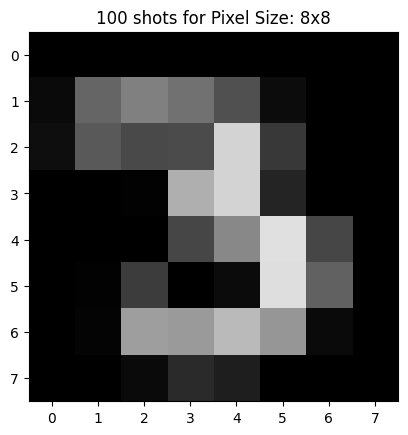

In [4]:
num_rows = 1
visualize_images_grid(num_pixels,num_rows, [X_train[2]],numOfShots)

### Creation of the quantum circuit

This is the circuit that we need to convert the classical image to a quantum state

In [5]:
import numpy as numpy

N = int(numpy.log2(num_pixels[0]))
pos_qubits = 2 * N
if method == 'FRQI':
    num_qubits = pos_qubits+1
elif method == 'NEQR':
    num_qubits = pos_qubits+8
elif method == 'OQIM':
    num_qubits = pos_qubits+2
elif method == 'default':
    #for amplitud encoding we needd at least log2(pixels)
    num_qubits = 2**N
print("For an image of "+str(num_pixels[0]*num_pixels[0]) +" pixels we need "+ str(num_qubits) +" qubits")

For an image of 64 pixels we need 7 qubits


In [6]:
def layer(W):
    for wire in range(num_qubits):
        qml.Rot(*W[wire], wires=wire)

    #for wires in ([0, 1], [1, 2], [2, 3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9], [9, 0]):
    entangling_gates = [(i, (i + 1) % num_qubits) for i in range(num_qubits)] 
    for wires in entangling_gates:
        qml.CNOT(wires)


In [7]:
def state_preparation(x):

    if method == 'FRQI':
        frqi = FRQI()
        circuit = frqi._create_FRQI_circ(x, measure_bool=False, printTime=printTime)
        qml.from_qiskit(circuit)()
    elif method == 'NEQR':
        neqr = NEQR()
        circuit = neqr._create_NEQR_circ(x, measure_bool=False, printTime=printTime)
        circuit = circuit.decompose().decompose()
        qml.from_qiskit(circuit)()
    elif method == 'OQIM':
        oqim = OQIM()
        circuit = oqim.create_OQIM_circ(x, measure_bool=False, printTime=printTime)
        qml.from_qiskit(circuit)()
    elif method =='default':
        qml.AmplitudeEmbedding(features=x,wires=range(num_qubits),pad_with = 0.)
        
    

In [8]:
dev = qml.device("qiskit.aer", wires=num_qubits)
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    
    return qml.expval(qml.PauliZ(0))

In [9]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [10]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [11]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [12]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [13]:
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

'''print("Weights:", weights_init)
print("Bias: ", bias_init)'''

'print("Weights:", weights_init)\nprint("Bias: ", bias_init)'

In [14]:
np.random.seed(0)
if method == 'default':
    X_train = np.array(X_train, requires_grad=False)
    X_train = preprocessing.normalize(X_train)
    X_test = np.array(X_test, requires_grad=False)
    X_test = preprocessing.normalize(X_test)
else:
     X_train = np.array(X_train, requires_grad=False)
     X_test = np.array(X_test, requires_grad=False)

Y_train = np.array([1 if x == 3 else -1 for x in Y_train],requires_grad=False)
Y_test = np.array([1 if x == 3 else -1 for x in Y_test],requires_grad=False)

In [15]:
opt = NesterovMomentumOptimizer(0.5)
num_it = 20
batch_size = 5
batch_train_size = 5

acc_train = []
costs = []
acc_val = []

weights = weights_init
bias = bias_init
for it in range(num_it):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    weights, bias,_,_ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    batch_index_train = np.random.randint(0, len(X_train), (batch_train_size,))
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_train[batch_index_train]]
    #acc = accuracy(Y_train, predictions)
    accTrain = accuracy(Y_train[batch_index_train],predictions)
    acc_train.append(accTrain)
    _cost = cost(weights,bias,X_train[batch_index_train],Y_train[batch_index_train])
    costs.append(_cost)

    if(it + 1)%2 == 0:
        print(f"Iter: {it+1:5d} | Cost: {_cost:0.7f} | Acc train: {accTrain:0.7f}")

Iter:     2 | Cost: 1.0037523 | Acc train: 0.6000000
Iter:     4 | Cost: 1.0883333 | Acc train: 0.4000000
Iter:     6 | Cost: 1.0569016 | Acc train: 0.4000000
Iter:     8 | Cost: 2.6425232 | Acc train: 0.0000000
Iter:    10 | Cost: 1.0324115 | Acc train: 0.6000000
Iter:    12 | Cost: 1.2269273 | Acc train: 0.4000000
Iter:    14 | Cost: 0.7742773 | Acc train: 0.8000000


In [ ]:
predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]


In [ ]:
predictions

In [ ]:
print(accuracy_score(Y_test, predictions))
print(precision_score(Y_test, predictions))
print(recall_score(Y_test, predictions))
print(f1_score(Y_test, predictions, average='macro'))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(acc_train, label='Train accurancy')
plt.legend(loc="lower right")
plt.ylim(0, 1)
plt.title("Train accuracy using NEQR technique")
plt.xlabel("Length of list (number)")
plt.ylabel("Time taken (seconds)")
plt.show()

In [ ]:
plt.plot(costs, label='Cost')
plt.legend(loc="lower right")
plt.ylim(0)
plt.title("Cost using NEQR technique")